<table style="width:100%; border:none;">
  <tr>
    <!-- Logo à esquerda -->
    <td style="width:90px;">
      <img src="../figs/logo.png" width="90">
    </td>
    <!-- Título centralizado -->
    <td style="text-align:center;">
      <h1 style="margin:0;">Projeto Final PAGD</h1>
        <p>
      <h4 style="margin:0; color:gray;"> Análise dos determinantes das despesas do INPS com cuidados de saúde</h4>
        <p>
      <h5 style="margin:0;">2010-2025 </h5>
    </td>
  </tr>
</table>

**Grupo: 3**  
* 1 - JOSÉ JAIR DA SILVACORREIA
* 2 - LEANDRO DO ROSARIO VIANA DUARTE
* 3 - FRÉDERIC DOS SANTOS
* 4 - JANICE VIVIANE LOPES DUARTE
* 5 - KIESSE DE OLIVEIRA DIOGO SE-I-KANDA

**Ano Letivo:** 2025/2026

## Definição do Problema
Este projeto analisa os fatores que influenciam o crescimento das despesas do INPS com cuidados de saúde no período de 2010 a 2025
Este notebook é a **versão de entrega** do projeto, baseado no trabalho do grupo (G3) e em **dados reais**.

**Objetivo:** compreender e prever a evolução da **despesa total** usando indicadores socioeconómicos (segurados, população ativa, inflação, salário médio, PIB, etc.), garantindo:
## Sumário:
- **AED** estruturada (limpeza + exploração + interpretação);
- **Teste de diagnostico** (normalidade, correlação, multicolinearidade,tendência/estacionaridade);
- **Regressão Linear** ( OLS);
- **Elasticidade**
- **Sensibilidade**
- **Previsões**(SARIMAX)
- **Machine Learning** com validação temporal e métricas;
- **Dashboard Streamlit** para comunicação;
- **Agent AI** para automação de validações e recomendações.



In [37]:
#  Configuração do projeto (imports internos e caminhos)
import sys
from pathlib import Path

# Se o notebook estiver em: projeto_pagd/notebooks/
ROOT_DIR = Path().resolve().parent

# Garantir imports de src/
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

DATA_RAW_DIR = ROOT_DIR / "data" / "raw"
DATA_PROCESSED_DIR = ROOT_DIR / "data" / "processed"
FIGS_DIR = ROOT_DIR / "figs"
REPORTS_DIR = ROOT_DIR / "reports"

for d in [DATA_RAW_DIR, DATA_PROCESSED_DIR, FIGS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

ROOT_DIR


WindowsPath('C:/Users/leand/Preparacao_Analise_Dados_Python_R/Projeto_Final_PAGD_05_02_2026/projeto_final_G3')

# Projeto Final — PAGD (Python)
##  Análise dos determinantes das despesas do INPS com cuidados de saúde (2010–2025)

    Este notebook **mantém todo o código e análise do V2**, mas agora está organizado com secções e explicações em Markdown,
para ficar alinhado com o enunciado (AED + Estatística + Séries Temporais + Machine Learning + Aplicação Streamlit + Agent AI).


## 0) Organização do projeto e importação de bibliotecas

In [34]:
# 0. IMPORTAÇÃO DE BIBLIOTECAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')


## 1) Leitura dos dados e consolidação

In [35]:

# 1. CARREGAR DADOS DO EXCEL

from pathlib import Path
import pandas as pd

ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / "data" / "raw"

file_path = DATA_DIR / "DADOS_DM_2010_2025_V2.xlsx"

df = pd.read_excel(file_path)
df.head()



df_variaveis = pd.read_excel(file_path, sheet_name='TAXA_COBERTURA')
df_variaveis = df_variaveis.rename(columns={'Unnamed: 0': 'ano'})
df_variaveis.columns = df_variaveis.columns.str.strip()


abas_despesas = ['SDO', 'Maternidade', 'CMS', 'ESTOMATOLOGIA', 'FISIOTERAPIA', 
                 'EXAMES_CLINICOS', 'AMED', 'PROTESE', 'SDU', 'TRANSPORTE', 
                 'EXTERNO', 'OUTRA_DESPESA']

despesas_dict = {}
for aba in abas_despesas:
    df_temp = pd.read_excel(file_path, sheet_name=aba)
    df_temp['ANO'] = pd.to_numeric(df_temp['ANO'], errors='coerce')
    df_temp = df_temp.dropna(subset=['ANO'])
    df_temp['ANO'] = df_temp['ANO'].astype(int)
    df_temp = df_temp.rename(columns={'Despesas': f'despesa_{aba.lower()}'})
    despesas_dict[aba] = df_temp[['ANO', f'despesa_{aba.lower()}']]


df_consolidado = df_variaveis.copy()
for aba, df_despesa in despesas_dict.items():
    col_name = f'despesa_{aba.lower()}'
    df_consolidado = pd.merge(df_consolidado, df_despesa.rename(columns={'ANO':'ano', f'despesa_{aba.lower()}': col_name}),
                              on='ano', how='left')

colunas_despesas = [col for col in df_consolidado.columns if col.startswith('despesa_')]
df_consolidado['despesa_total'] = df_consolidado[colunas_despesas].sum(axis=1)


Nesta etapa, carregamos os dados da folha (TAXA_COBERTURA) e das despesas (abas diferentes).
As colunas foram padronizadas e unidas em um DataFrame único, df_consolidado.
Criamos a variável despesa_total, que representa a soma de todas as despesas por ano.
Garantimos que os anos fossem inteiros e não houvesse duplicações de colunas.

In [4]:
df_consolidado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ano                           14 non-null     int64  
 1   População                     14 non-null     float64
 2   População_Ativa               14 non-null     float64
 3   População_empregada           14 non-null     float64
 4   Segurados                     14 non-null     int64  
 5   Pensionista_INPS              14 non-null     int64  
 6   Pensionista_FP                14 non-null     int64  
 7   Pensionistas_Total            14 non-null     int64  
 8   Salario_Médio_Segurados       14 non-null     int64  
 9   Taxa_cobertura_Pop_Empregada  14 non-null     float64
 10  Taxa_cobertura_Residente      14 non-null     float64
 11  Beneficiários                 14 non-null     int64  
 12  PIB                           13 non-null     float64
 13  Inflaçã

## 3) Análise Exploratória de Dados (AED)

Nesta fase exploramos a distribuição das variáveis, tendências e relações (correlação). O objetivo é **entender os dados antes de modelar** e identificar potenciais problemas como outliers, assimetrias e multicolinearidade.

,ano,População,População_Ativa,População_empregada,Segurados,Pensionista_INPS,Pensionista_FP,Pensionistas_Total,Salario_Médio_Segurados,Taxa_cobertura_Pop_Empregada,...,despesa_estomatologia,despesa_fisioterapia,despesa_exames_clinicos,despesa_amed,despesa_protese,despesa_sdu,despesa_transporte,despesa_externo,despesa_outra_despesa,despesa_total
count,14.0000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,...,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01
mean,2017.5000,522267.564453,222611.536359,194447.918741,94005.071429,7658.428571,7421.214286,15079.642857,46216.142857,0.482868,...,1.569534e+08,3.968689e+07,4.214040e+07,6.977286e+08,2.262381e+08,1.370612e+08,1.136858e+08,4.117141e+08,6.055207e+06,2.539559e+09
std,4.1833,18208.629124,10733.485147,10295.906502,18625.789522,1629.343649,2060.662521,3668.386726,732.143834,0.090513,...,4.433061e+07,1.718202e+07,2.782385e+07,1.596282e+08,1.153407e+08,6.699850e+07,2.429424e+07,1.828825e+08,3.331519e+06,7.228397e+08
min,2011.0000,499653.960843,203497.179829,178571.365029,72143.000000,5758.000000,4597.000000,10355.000000,44970.000000,0.390838,...,9.370800e+07,1.615000e+07,4.670000e+05,4.902920e+08,9.949200e+07,5.255800e+07,6.129200e+07,1.891730e+08,1.964000e+06,1.691654e+09
25%,2014.2500,507215.749459,216504.784822,186946.009733,74851.500000,6205.750000,5566.250000,11772.000000,45717.000000,0.399394,...,1.237440e+08,2.198725e+07,2.823225e+07,5.816960e+08,1.200662e+08,9.522925e+07,1.014105e+08,2.405218e+08,3.264500e+06,1.905332e+09
50%,2017.5000,515255.470644,221945.245996,192532.338858,95251.500000,7371.500000,7565.500000,14937.000000,46181.500000,0.474610,...,1.450915e+08,4.183300e+07,3.797980e+07,6.594620e+08,1.951485e+08,1.078130e+08,1.096225e+08,4.077345e+08,5.704000e+06,2.416920e+09
75%,2020.7500,535651.500000,230202.833722,202559.601890,105166.750000,8815.250000,8947.250000,17740.000000,46683.250000,0.542231,...,1.848302e+08,5.168825e+07,6.391225e+07,8.116600e+08,3.169752e+08,1.737132e+08,1.235630e+08,5.086058e+08,9.160750e+06,2.959128e+09
max,2024.0000,555838.997547,246680.349983,211579.560057,124601.000000,10660.000000,10653.000000,20772.000000,47385.000000,0.626406,...,2.443178e+08,6.563500e+07,9.170700e+07,1.050069e+09,4.291083e+08,2.655582e+08,1.610330e+08,7.318563e+08,1.061200e+07,3.959108e+09


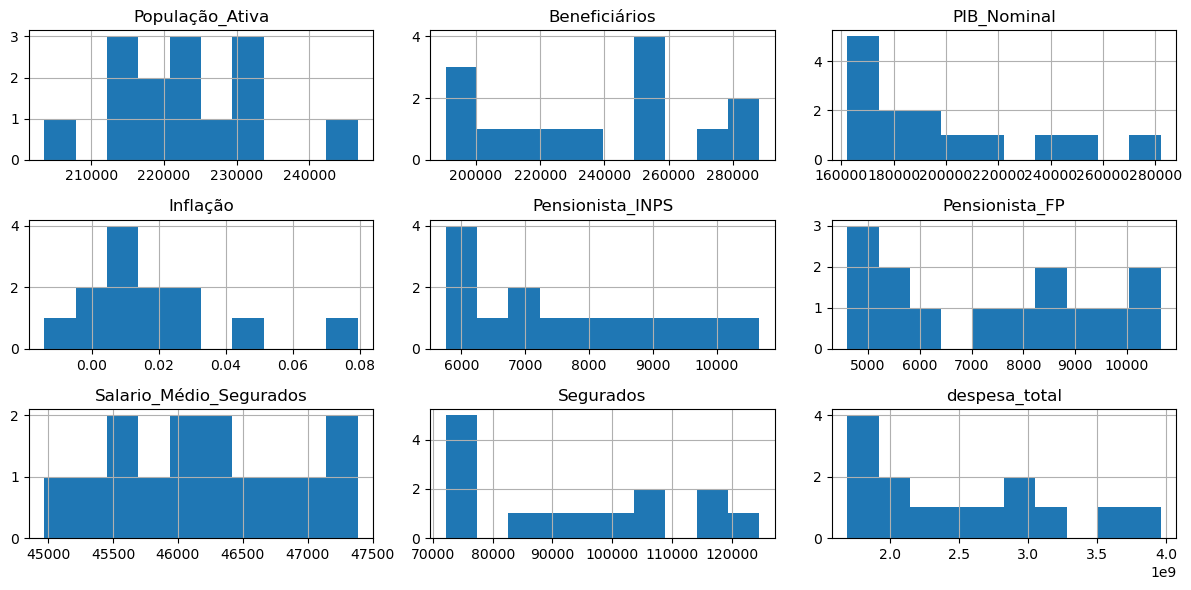

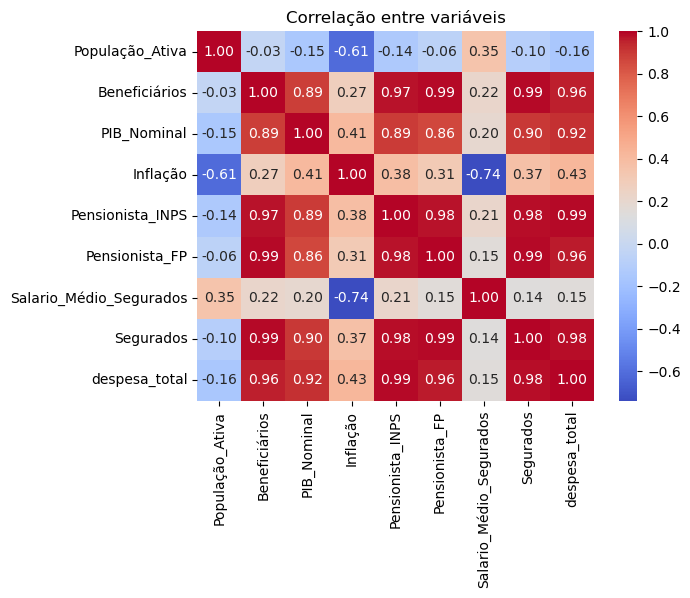

In [5]:
# Estatísticas descritivas
display(df_consolidado.describe())

# Variáveis para visualizar
variaveis_exibir = ['População_Ativa', 'Beneficiários', 'PIB_Nominal', 'Inflação','Pensionista_INPS','Pensionista_FP','Salario_Médio_Segurados','Segurados', 'despesa_total']


df_consolidado[variaveis_exibir].hist(figsize=(12,6), bins=10)
plt.tight_layout()
plt.show()

# Matriz de correlação
corr = df_consolidado[variaveis_exibir].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis")
plt.show()


Dado que as variáveis Segurados (r = 0,98) e Beneficiários (r = 0,96) apresentam correlação muito elevada com a despesa total, optou-se por manter apenas a variável Segurados no modelo. Esta escolha visa reduzir redundâncias, melhorar a estabilidade estatística do modelo e garantir uma interpretação mais clara e consistente dos resultados.

## 4) Diagnóstico pré-estimação do modelo

###  4.1) Analise de Multicolenearidade 

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


# Selecionar apenas as duas variáveis
X = df_consolidado[['Segurados', 'Beneficiários','Pensionista_INPS','Pensionista_FP']]

# Adicionar constante (necessário para VIF)
X = sm.add_constant(X)

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["variavel"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif_data)


,variavel,VIF
0,const,660.164413
1,Segurados,87.690653
2,Beneficiários,58.235504
3,Pensionista_INPS,33.945368
4,Pensionista_FP,58.737584


A análise dos fatores de inflação da variância (VIF) revela a existência de elevada multicolinearidade entre as variáveis associadas à população coberta pelo sistema, nomeadamente Segurados, Beneficiários e Pensionistas.

###  4.2)  Teste de normalidade 

In [7]:

variaveis_potenciais = [
    'População',
    'População_Ativa',
    'População_empregada',
    'Segurados',
    'Salario_Médio_Segurados',
    'Beneficiários',
    'PIB_Nominal',
    'Inflação',
    'Pensionista_INPS',
    'Pensionista_FP',
    'Pensionistas_Total',          
    
]

variaveis_disponiveis = [v for v in variaveis_potenciais if v in df_consolidado.columns]

df_model = df_consolidado[['despesa_total'] + variaveis_disponiveis].dropna()

# Transformações logaritmica para variaveis que não seguem normal
transformadas = {}
for var in variaveis_disponiveis:
    stat, p = shapiro(df_model[var])
    if p <= 0.05 or var in ['pib', 'inflacao']:
        df_model[f'log_{var}'] = np.log1p(df_model[var])
        transformadas[var] = f'log_{var}'
    else:
        transformadas[var] = var
    print(f"Shapiro {var}: p-value={p:.3f} {'Normal' if p>0.05 else 'Não normal ou transformado'}")

print("\nTransformações aplicadas:")
for k,v in transformadas.items():
    print(f"{k} -> {v}")


Shapiro População: p-value=0.207 Normal
Shapiro População_Ativa: p-value=0.905 Normal
Shapiro População_empregada: p-value=0.380 Normal
Shapiro Segurados: p-value=0.101 Normal
Shapiro Salario_Médio_Segurados: p-value=0.955 Normal
Shapiro Beneficiários: p-value=0.350 Normal
Shapiro PIB_Nominal: p-value=0.088 Normal
Shapiro Inflação: p-value=0.100 Normal
Shapiro Pensionista_INPS: p-value=0.262 Normal
Shapiro Pensionista_FP: p-value=0.427 Normal
Shapiro Pensionistas_Total: p-value=0.395 Normal

Transformações aplicadas:
População -> População
População_Ativa -> População_Ativa
População_empregada -> População_empregada
Segurados -> Segurados
Salario_Médio_Segurados -> Salario_Médio_Segurados
Beneficiários -> Beneficiários
PIB_Nominal -> PIB_Nominal
Inflação -> Inflação
Pensionista_INPS -> Pensionista_INPS
Pensionista_FP -> Pensionista_FP
Pensionistas_Total -> Pensionistas_Total


A normalidade das variáveis independentes foi avaliada através do teste de Shapiro-Wilk. Os resultados indicam que, de forma geral, as variáveis apresentam distribuição aproximadamente normal, não se rejeitando a hipótese de normalidade ao nível de significância de 5%.
Para variáveis com comportamento estruturalmente assimétrico, nomeadamente o Produto Interno Bruto (PIB), foi aplicada uma transformação logarítmica, com o objetivo de reduzir a assimetria e melhorar a estabilidade estatística do modelo. Importa salientar que a regressão linear exige a normalidade dos resíduos, sendo estas transformações um reforço à robustez e interpretabilidade dos resultados.

### 4.3) Diagnóstico de estacionaridade

Como os dados são anuais (2011–2025), verificamos estacionaridade (ADF/KPSS) e tendência, para reduzir risco de regressões espúrias.

In [13]:
from statsmodels.tsa.stattools import adfuller, kpss

# 3. FUNÇÃO PARA TESTES DE ESTACIONARIDADE

def testar_estacionaridade(serie, nome):
    resultado = {}

    # Garantir que não há NaN
    serie = serie.dropna()

    # ADF - Augmented Dickey-Fuller
    adf_test = adfuller(serie, autolag='AIC')
    resultado['ADF_stat'] = adf_test[0]
    resultado['ADF_p'] = adf_test[1]

    # KPSS - Kwiatkowski-Phillips-Schmidt-Shin
    try:
        kpss_test = kpss(serie, regression='c', nlags='auto')
        resultado['KPSS_stat'] = kpss_test[0]
        resultado['KPSS_p'] = kpss_test[1]
    except Exception as e:
        resultado['KPSS_stat'] = np.nan
        resultado['KPSS_p'] = np.nan

    # Output
    print(f"\n {nome}")
    print(f"ADF p-value   : {resultado['ADF_p']:.3f} → "
          f"{'Estacionária' if resultado['ADF_p'] < 0.05 else 'Não estacionária'}")
    print(f"KPSS p-value  : {resultado['KPSS_p']:.3f} → "
          f"{'Estacionária' if resultado['KPSS_p'] > 0.05 else 'Não estacionária'}")

    return resultado


# Garantir ausência de valores em falta
df_model_limpo = df_model.dropna()

# Variáveis a testar (dependente + explicativas transformadas)
variaveis_teste = ['despesa_total'] + list(transformadas.values())


## Execução dos teste 

resultados_estacionaridade = {}

for var in variaveis_teste:
    print("\n------------------------------")
    resultados_estacionaridade[var] = testar_estacionaridade(
        df_model_limpo[var],
        var
    )



------------------------------

 despesa_total
ADF p-value   : 0.997 → Não estacionária
KPSS p-value  : 0.013 → Não estacionária

------------------------------

 População
ADF p-value   : 0.427 → Não estacionária
KPSS p-value  : 0.100 → Estacionária

------------------------------

 População_Ativa
ADF p-value   : 0.009 → Estacionária
KPSS p-value  : 0.100 → Estacionária

------------------------------

 População_empregada
ADF p-value   : 0.218 → Não estacionária
KPSS p-value  : 0.093 → Estacionária

------------------------------

 Segurados
ADF p-value   : 1.000 → Não estacionária
KPSS p-value  : 0.012 → Não estacionária

------------------------------

 Salario_Médio_Segurados
ADF p-value   : 0.106 → Não estacionária
KPSS p-value  : 0.100 → Estacionária

------------------------------

 Beneficiários
ADF p-value   : 0.000 → Estacionária
KPSS p-value  : 0.011 → Não estacionária

------------------------------

 PIB_Nominal
ADF p-value   : 0.997 → Não estacionária
KPSS p-value  : 0

As séries temporais foram avaliadas com os testes ADF e KPSS. Variáveis como despesa_total e Segurados são claramente não estacionárias (I(1)), enquanto População_Ativa e log_PIB são estacionárias (I(0)). Para séries com resultados ambíguos, adotou-se abordagem conservadora, tratando-as como não estacionárias ou aplicando primeira diferença antes da regressão.

In [14]:

# 4. DEFINIÇÃO DAS VARIÁVEIS PARA REGRESSÃO

# Variáveis I(1) → aplicadas primeira diferença
variaveis_I1 = ['despesa_total', 'Segurados']

# Variáveis I(0) → mantidas em nível
variaveis_I0 = ['População_Ativa']

# Variáveis ambíguas → tratadas como I(1)
variaveis_ambiguas = ['População', 'População_empregada', 'Salario_Médio_Segurados', 
                      'Beneficiários', 'Inflação','Pensionista_INPS','Pensionista_FP','PIB_Nominal','Pensionistas_Total']

# Combinar todas as variáveis a diferenciar
variaveis_para_diferenciar = variaveis_I1 + variaveis_ambiguas

# Criar DataFrame com primeiras diferenças
df_model_diff = df_model.copy()
for var in variaveis_para_diferenciar:
    df_model_diff[f'd_{var}'] = df_model_diff[var].diff()

# Variáveis para regressão — removendo a dependente
X_vars = [f'd_{v}' for v in variaveis_para_diferenciar if v != 'despesa_total'] + variaveis_I0
y_var = 'd_despesa_total'  # variável dependente em diferença

# Remover NaN resultantes da diferença
df_model_diff = df_model_diff.dropna(subset=X_vars + [y_var])

# Criar X e y finais
X = df_model_diff[X_vars]
y = df_model_diff[y_var]

print("Variáveis independentes para regressão:")
print(X.columns.tolist())
print("\nDimensão do DataFrame para regressão:", X.shape)


Variáveis independentes para regressão:
['d_Segurados', 'd_População', 'd_População_empregada', 'd_Salario_Médio_Segurados', 'd_Beneficiários', 'd_Inflação', 'd_Pensionista_INPS', 'd_Pensionista_FP', 'd_PIB_Nominal', 'd_Pensionistas_Total', 'População_Ativa']

Dimensão do DataFrame para regressão: (12, 11)


As variáveis não estacionárias e ambíguas foram transformadas por primeira diferença, enquanto as séries estacionárias foram mantidas em nível. O conjunto final de regressão inclui a variação da despesa total como dependente e todas as variáveis explicativas apropriadas, prontas para o modelo.

## 5) Modelação clássica (OLS) — baseline econométrico

### 5.1) Modelo 1

In [16]:

#  REGRESSÃO OLS

import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
print(model.summary())


# COEFICIENTES PADRONIZADOS

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr = LinearRegression()
lr.fit(X_scaled, y)

coef = pd.DataFrame({
    'variavel': X.columns,
    'coeficiente': lr.coef_,
    'coef_abs': np.abs(lr.coef_)
}).sort_values('coef_abs', ascending=False)

display(coef)


                            OLS Regression Results                            
Dep. Variable:        d_despesa_total   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     1.474
Date:                Mon, 09 Feb 2026   Prob (F-statistic):              0.571
Time:                        17:24:09   Log-Likelihood:                -228.50
No. Observations:                  12   AIC:                             479.0
Df Residuals:                       1   BIC:                             484.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

,variavel,coeficiente,coef_abs
2,d_População_empregada,1.450683e+08,1.450683e+08
1,d_População,1.447635e+08,1.447635e+08
0,d_Segurados,-1.278759e+08,1.278759e+08
5,d_Inflação,1.206885e+08,1.206885e+08
6,d_Pensionista_INPS,1.089020e+08,1.089020e+08
9,d_Pensionistas_Total,9.214870e+07,9.214870e+07
7,d_Pensionista_FP,6.756718e+07,6.756718e+07
8,d_PIB_Nominal,4.327108e+07,4.327108e+07
3,d_Salario_Médio_Segurados,2.401915e+07,2.401915e+07
10,População_Ativa,-1.657087e+07,1.657087e+07


O modelo apresenta um R² de 0,936, indicando que explica 93,6% da variação das despesas totais. O R² ajustado é muito baixo, refletindo a pequena amostra em relação ao número de variáveis, e alguns coeficientes apresentam sinais negativos possivelmente devido à multicolinearidade.

In [17]:
# =========================================================
# Teste de Multicolinearidade (VIF)
# =========================================================
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Usar as variáveis independentes que já ajustamos (primeiras diferenças + I(0) em nível)
variaveis_independentes = X.columns.tolist()  # X do modelo de regressão já preparado

# Adicionar constante (necessário para statsmodels)
X_vif = add_constant(X[variaveis_independentes], has_constant='add')

# Calcular VIF
vif_data = pd.DataFrame()
vif_data['Variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== VIF (Multicolinearidade) ===")
print(vif_data)


=== VIF (Multicolinearidade) ===
                     Variável           VIF
0                       const  1.012562e+04
1                 d_Segurados  1.174674e+02
2                 d_População  2.641989e+01
3       d_População_empregada  1.650558e+01
4   d_Salario_Médio_Segurados  1.606746e+01
5             d_Beneficiários  4.326267e+00
6                  d_Inflação  2.161163e+01
7          d_Pensionista_INPS           inf
8            d_Pensionista_FP           inf
9               d_PIB_Nominal  4.335206e+01
10       d_Pensionistas_Total           inf
11            População_Ativa  1.798142e+01


O VIF evidencia multicolinearidade severa em d_Pensionista_INPS, d_Pensionista_FP e d_Pensionistas_Total (inf), e valores elevados em d_Segurados, d_População e d_PIB_Nominal. 

In [18]:
# VIF sem sem d_População e d_Beneficiários e População_Ativa

In [19]:
# =========================================================
# Teste de Multicolinearidade (VIF) - 
# =========================================================
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Variáveis independentes ajustadas
variaveis_independentes_vif = [v for v in X.columns if v not in ['d_População', 'd_Beneficiários','População_Ativa','d_Inflação','d_População_empregada','d_Pensionista_FP','d_Pensionista_INPS']]

# Criar matriz para VIF
X_vif = add_constant(X[variaveis_independentes_vif], has_constant='add')

# Calcular VIF
vif_data = pd.DataFrame()
vif_data['Variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== VIF (Multicolinearidade) ===")
print(vif_data)


=== VIF (Multicolinearidade) ===
                    Variável        VIF
0                      const  10.620153
1                d_Segurados   3.921931
2  d_Salario_Médio_Segurados   2.148685
3              d_PIB_Nominal   2.427397
4       d_Pensionistas_Total   2.443995


## 5.2) Modelo 2  

Aqui reformulamos o problema como previsão supervisionada e avaliamos modelos com métricas e validação temporal.

In [20]:
# 
# 1. Preparação das variáveis (sem d_População_empregada)
# 
# Variáveis independentes
X_vars_adjusted = [v for v in X.columns if v not in [ 'd_População','d_Beneficiários','População_Ativa','d_PIB_Nominal','d_Pensionista_FP','d_Inflação','d_Pensionistas_Total','d_Salario_Médio_Segurados']]

# Criar X e y ajustados
X_adjusted = X[X_vars_adjusted]
y_adjusted = y.copy()

print("Variáveis independentes ajustadas:")
print(X_adjusted.columns.tolist())

# 
# 2. Regressão OLS
#
import statsmodels.api as sm

X_sm = sm.add_constant(X_adjusted)
model_adjusted = sm.OLS(y_adjusted, X_sm).fit()
print(model_adjusted.summary())

# 
# 3. Coeficientes padronizados
# 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_adjusted)
lr = LinearRegression()
lr.fit(X_scaled, y_adjusted)

coef_adjusted = pd.DataFrame({
    'variavel': X_adjusted.columns,
    'coeficiente': lr.coef_,
    'coef_abs': np.abs(lr.coef_)
}).sort_values('coef_abs', ascending=False)

display(coef_adjusted)


Variáveis independentes ajustadas:
['d_Segurados', 'd_População_empregada', 'd_Pensionista_INPS']
                            OLS Regression Results                            
Dep. Variable:        d_despesa_total   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 09 Feb 2026   Prob (F-statistic):            0.00440
Time:                        17:26:03   Log-Likelihood:                -235.68
No. Observations:                  12   AIC:                             479.4
Df Residuals:                       8   BIC:                             481.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------

,variavel,coeficiente,coef_abs
2,d_Pensionista_INPS,8.780666e+07,8.780666e+07
0,d_Segurados,8.067061e+07,8.067061e+07
1,d_População_empregada,6.880150e+07,6.880150e+07


Foi criada uma versão ajustada do modelo, removendo variáveis altamente correlacionadas para reduzir multicolinearidade, e aplicada uma regressão OLS sobre essas variáveis. Em seguida, os coeficientes foram padronizados para comparar o impacto relativo de cada variável sobre a variação da despesa total.

In [21]:
from sklearn.preprocessing import StandardScaler

# Padronizar variáveis independentes
scaler = StandardScaler()

# CORREÇÃO: Use df_model_diff em vez de df
X_scaled = scaler.fit_transform(df_model_diff[['d_Segurados', 'd_População_empregada', 'd_Pensionista_INPS']])
X_scaled = sm.add_constant(X_scaled)

# Modelo com variáveis padronizadas
modelo_scaled = sm.OLS(df_model_diff['d_despesa_total'], X_scaled).fit()

print(modelo_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:        d_despesa_total   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 09 Feb 2026   Prob (F-statistic):            0.00440
Time:                        17:26:16   Log-Likelihood:                -235.68
No. Observations:                  12   AIC:                             479.4
Df Residuals:                       8   BIC:                             481.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.502e+08    2.9e+07      5.185      0.0

As variáveis independentes selecionadas (d_Segurados, d_População_empregada, d_Pensionista_INPS) foram padronizadas para permitir comparação de magnitudes. Em seguida, foi ajustado um modelo OLS com essas variáveis padronizadas, facilitando a interpretação relativa dos coeficientes.

O modelo explica cerca de 79% da variação da despesa total (R² = 0,790; R² ajustado = 0,711). Os resíduos apresentam distribuição aproximadamente normal (Omnibus p = 0,860; Jarque-Bera p = 0,801) e ausência de autocorrelação (Durbin-Watson = 2,082). Todos os coeficientes são positivos e estatisticamente significativos ou próximos do nível de 5%.

  ## 6) ELASTICIDADE APROXIMADA

In [23]:
# 

# 
def calcular_elasticidade(df, variavel_alvo='despesa_total', col_ano='ano'):
    # Seleciona apenas colunas numéricas diferentes do ano e da variável alvo
    variaveis = [v for v in df.columns if v not in [col_ano, variavel_alvo] and 
                 np.issubdtype(df[v].dtype, np.number)]
    
    elasticidade = []

    for var in variaveis:
        df_temp = df[[variavel_alvo, var]].dropna().copy()
        
        # Calcula variação percentual (primeira diferença percentual)
        df_temp[f'{var}_pct'] = df_temp[var].pct_change()
        df_temp[f'{variavel_alvo}_pct'] = df_temp[variavel_alvo].pct_change()
        
        # Remove valores infinitos ou NaN
        df_temp = df_temp.replace([np.inf, -np.inf], np.nan).dropna()
        
        # Calcula correlação como proxy de elasticidade
        if len(df_temp) > 2:
            corr = df_temp[f'{var}_pct'].corr(df_temp[f'{variavel_alvo}_pct'])
            elasticidade.append({'variavel': var, 'elasticidade_aprox': corr})
    
    # Ordena pelo valor absoluto da elasticidade
    df_elasticidade = pd.DataFrame(elasticidade).sort_values(
        'elasticidade_aprox', key=lambda x: x.abs(), ascending=False
    )
    
    print("\n=== ELASTICIDADE APROXIMADA ===")
    display(df_elasticidade)
    
    return df_elasticidade

elasticidade_total = calcular_elasticidade(df_consolidado)



=== ELASTICIDADE APROXIMADA ===


,variavel,elasticidade_aprox
20,despesa_amed,0.924642
23,despesa_transporte,0.764830
22,despesa_sdu,0.763057
4,Pensionista_INPS,0.726549
3,Segurados,0.652186
21,despesa_protese,0.647693
18,despesa_fisioterapia,0.586994
13,PIB_Nominal,0.553391
6,Pensionistas_Total,0.518450
17,despesa_estomatologia,0.465061


A elasticidade foi estimada como a correlação entre a variação percentual de cada variável independente e a variação percentual da despesa total. Valores próximos de ±1 indicam forte sensibilidade proporcional da despesa em relação à variável, enquanto valores próximos de 0 refletem impacto reduzido. Sinais positivos indicam que um aumento na variável eleva a despesa total, ao passo que sinais negativos sugerem efeito inverso.

Os resultados apontam que as despesas com assistência medicamentosa exercem o maior impacto proporcional sobre a despesa total, sendo, portanto, um determinante estrutural relevante para a sustentabilidade financeira do sistema.

## 6) ANÁLISE DE SENSIBILIDADE ±5%

ANÁLISE DE SENSIBILIDADE - DESPESA_TOTAL

Sensibilidade aproximada para ±5% de variação:


,variavel,corr,impacto_±5%
0,Pensionista_INPS,0.987598,4.937990
1,despesa_protese,0.986994,4.934972
2,despesa_externo,0.982869,4.914343
3,Segurados,0.982132,4.910658
4,Pensionistas_Total,0.978428,4.892138
5,despesa_amed,0.973185,4.865926


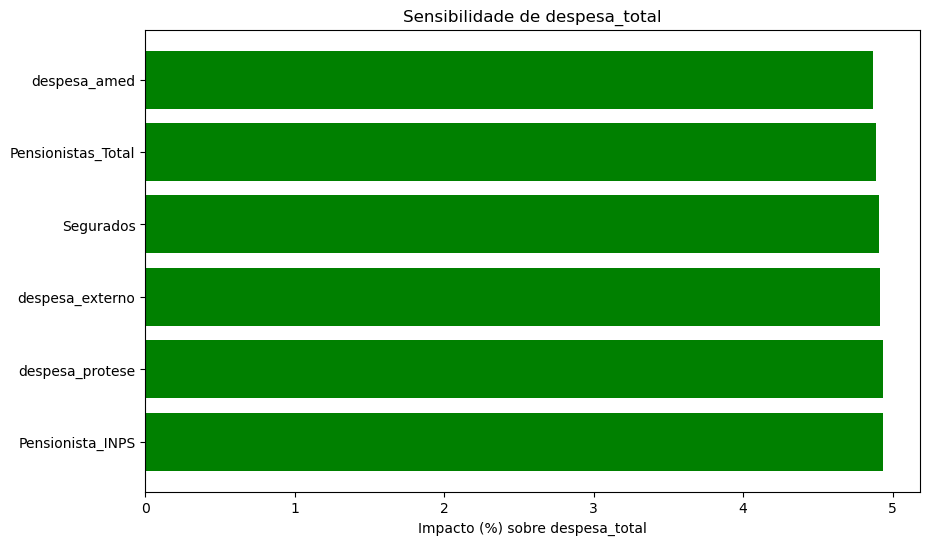

In [36]:
# 
def analise_sensibilidade(df, variavel_alvo='despesa_total', top_n=5, variacao=0.05):
    """
    Analisa o impacto percentual sobre a variável alvo simulando ±variacao
    Args:
        df : DataFrame com os dados
        variavel_alvo : variável dependente
        top_n : número de variáveis mais correlacionadas a considerar
        variacao : variação percentual simulada (ex: 0.05 = 5%)
    Returns:
        df_sensibilidade : DataFrame com impacto aproximado
    """
    ultima_obs = df.dropna().iloc[-1]  # última observação válida
    
    print("="*60)
    print(f"ANÁLISE DE SENSIBILIDADE - {variavel_alvo.upper()}")
    print("="*60)
    
    # Selecionar variáveis mais correlacionadas
    correlacoes = {}
    for var in df.columns:
        if var not in ['ano', variavel_alvo] and np.issubdtype(df[var].dtype, np.number):
            corr = df[var].corr(df[variavel_alvo])
            if not pd.isna(corr) and abs(corr) > 0.3:  # filtra correlação relevante
                correlacoes[var] = corr
    
    # Top N variáveis
    top_vars = sorted(correlacoes.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    sensibilidade = []
    for var, corr in top_vars:
        valor = ultima_obs[var]
        if valor != 0:
            impacto = corr * variacao * 100  # ±5% simulado
            sensibilidade.append({'variavel': var, 'corr': corr, f'impacto_±{int(variacao*100)}%': impacto})
    
    df_sensibilidade = pd.DataFrame(sensibilidade)
    print(f"\nSensibilidade aproximada para ±{int(variacao*100)}% de variação:")
    display(df_sensibilidade)
    
    # Visualização
    fig, ax = plt.subplots(figsize=(10,6))
    colors = ['green' if x > 0 else 'red' for x in df_sensibilidade[f'impacto_±{int(variacao*100)}%']]
    ax.barh(df_sensibilidade['variavel'], df_sensibilidade[f'impacto_±{int(variacao*100)}%'], color=colors)
    ax.set_xlabel(f'Impacto (%) sobre {variavel_alvo}')
    ax.set_title(f'Sensibilidade de {variavel_alvo}')
    ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    plt.show()
    
    return df_sensibilidade

# =========================================================
# APLICAR A FUNÇÃO COM Variação de 5%
# =========================================================
sensibilidade_total = analise_sensibilidade(df_consolidado, variavel_alvo='despesa_total', top_n=6, variacao=0.05)


Todas as variáveis listadas têm correlação positiva alta (>0.97).
Todas têm impacto próximo de 5% na despesa total para uma variação de 5%. Isso indica que são os principais motores das despesas.


## 7) Previsão das despesas para os proximos 5 anos 

In [26]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

y = df_consolidado['despesa_total']

# Variáveis exógenas 
exog = df_consolidado[[ 'Segurados','População_empregada','Pensionista_INPS']]


In [27]:
df_model=df_consolidado

In [28]:
# Ajustar SARIMAX
modelo_sarimax = SARIMAX(y,
                         order=(1,1,1),
                         seasonal_order=(0,0,0,0),
                         exog=exog,
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado = modelo_sarimax.fit(disp=False)
print(resultado.summary())


                               SARIMAX Results                                
Dep. Variable:          despesa_total   No. Observations:                   14
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -218.984
Date:                Mon, 09 Feb 2026   AIC                            449.968
Time:                        17:30:09   BIC                            452.355
Sample:                             0   HQIC                           448.463
                                 - 14                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Segurados            2.376e+04   1.75e+04      1.361      0.173   -1.04e+04     5.8e+04
População_empregada  4897.4954   3853.659      1.271      0.204   -2655.538    1.25e+04
Pensionista_INPS

O modelo SARIMAX indica que nenhuma variável independente é estatisticamente significativa ao nível convencional, embora o número de Segurados apresente o maior efeito positivo sobre as despesas totais. Os termos de AR(1) e MA(1) não mostram relevância estatística, e os resíduos não apresentam autocorrelação (Ljung-Box Q = 0,05, Prob(Q) = 0,82) nem heterocedasticidade (H = 0,52, Prob(H) = 0,54), sugerindo variância constante e ajuste adequado da série.

In [29]:
#  Calcular crescimento histórico médio de variaveis selecionadas 
exog_vars = ['Segurados','População_empregada','Pensionista_INPS']

crescimento = df_consolidado[exog_vars].pct_change().mean()

crescimento_segurados = crescimento['Segurados']
crescimento_pop_emp = crescimento['População_empregada']
crescimento_pensionistas = crescimento['Pensionista_INPS']
print(f"Crescimento médio anual histórico:")
print(f"Segurados: {crescimento_segurados:.4%}")
print(f"População Empregada: {crescimento_pop_emp:.4%}")
print(f"Pensionistas: {crescimento_pensionistas:.4%}")

Crescimento médio anual histórico:
Segurados: 4.3628%
População Empregada: 1.0506%
Pensionistas: 4.8654%


Foi calculado o crescimento percentual médio anual das variáveis selecionadas (Segurados, População_empregada e Pensionista_INPS) a partir da série histórica. Esse indicador permite avaliar a taxa média de crescimento anual de cada grupo, servindo de referência para as projeções

In [30]:

# Definindo o ano base e anos de projeção 

ultimo_ano = 2024  # último ano conhecido
anos_futuros = 2030 - ultimo_ano  # número de anos a prever

#
#  Últimos valores das variáveis exógenas
#
ultimo_segurados = df_consolidado['Segurados'].iloc[-1]
ultimo_pop_emp = df_consolidado['População_empregada'].iloc[-1]
ultimo_Pensionista = df_consolidado['Pensionista_INPS'].iloc[-1]

exog_futura = pd.DataFrame({
    'Segurados': [ultimo_segurados * (1 + crescimento_segurados)**i for i in range(1, anos_futuros+1)],
    'População_empregada': [ultimo_pop_emp * (1 + crescimento_pop_emp)**i for i in range(1, anos_futuros+1)],
    'Pensionista_INPS': [ultimo_Pensionista * (1 + crescimento_pensionistas)**i for i in range(1, anos_futuros+1)]
})



In [31]:
#  Previsão com SARIMAX

previsao = resultado.get_forecast(steps=anos_futuros, exog=exog_futura)
previsao_valores = previsao.predicted_mean
previsao_intervalo = previsao.conf_int()


# Criar anos futuros reais

anos_previstos = range(ultimo_ano + 1, ultimo_ano + anos_futuros + 1)


# Mostrar resultados

for i, ano in enumerate(anos_previstos):
    print(f"Ano {ano}: Previsão = {previsao_valores.iloc[i]:,.0f} | IC 95% = [{previsao_intervalo.iloc[i,0]:,.0f}, {previsao_intervalo.iloc[i,1]:,.0f}]")



Ano 2025: Previsão = 4,210,587,500 | IC 95% = [4,043,556,135, 4,377,618,866]
Ano 2026: Previsão = 4,473,707,511 | IC 95% = [4,247,465,769, 4,699,949,252]
Ano 2027: Previsão = 4,748,499,068 | IC 95% = [4,474,539,183, 5,022,458,954]
Ano 2028: Previsão = 5,035,562,455 | IC 95% = [4,721,165,153, 5,349,959,757]
Ano 2029: Previsão = 5,335,451,022 | IC 95% = [4,985,240,468, 5,685,661,576]
Ano 2030: Previsão = 5,648,753,492 | IC 95% = [5,266,068,413, 6,031,438,570]


Foi realizada uma previsão da despesa total para os anos futuros usando o modelo SARIMAX, com variáveis explicativas futuras (exog_futura). Para cada ano, foram calculados valores previstos e intervalos de confiança de 95%, permitindo quantificar a incerteza da projeção.

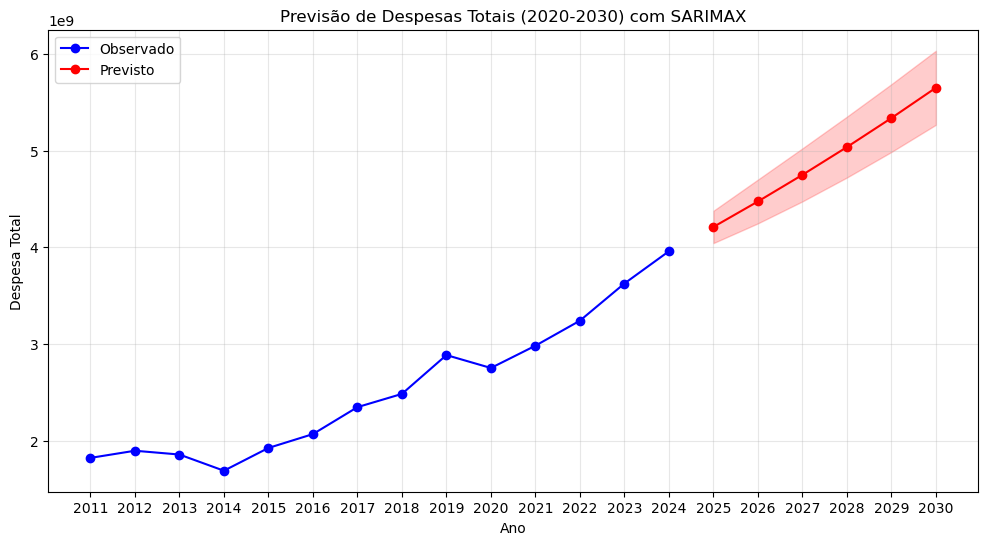

In [32]:
# 6. Visualizar gráfico (histórico + previsão)

import matplotlib.pyplot as plt

# Anos históricos reais
anos_historicos = df_model['ano'] if 'ano' in df_model.columns else range(ultimo_ano - len(df_model) + 1, ultimo_ano + 1)

plt.figure(figsize=(12,6))

# Linha histórica
plt.plot(anos_historicos, df_model['despesa_total'], label='Observado', marker='o', color='blue')

# Linha prevista
plt.plot(list(anos_previstos), previsao_valores.values, label='Previsto', marker='o', color='red')

# Intervalo de confiança
plt.fill_between(anos_previstos,
                 previsao_intervalo.iloc[:,0],
                 previsao_intervalo.iloc[:,1],
                 color='red', alpha=0.2)

plt.xlabel("Ano")
plt.ylabel("Despesa Total")
plt.title("Previsão de Despesas Totais (2020-2030) com SARIMAX")
plt.xticks(list(anos_historicos) + list(anos_previstos))
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 10) Conclusões e limitações

    **O que aprendemos**
    
- Quais variáveis se associam mais às despesas totais (interpretação baseada nos resultados).
- Como a multicolinearidade influencia a escolha de variáveis.
- Desempenho preditivo dos modelos de ML e utilidade prática para apoio à decisão.

**Limitações**
- Amostra pequena (série anual 2010–2025).
- Possível tendência/não-estacionaridade em algumas variáveis.
- Resultados devem ser interpretados com cautela (correlação ≠ causalidade).

**Próximos passos**
- Atualização anual automática (pipeline + agente).
- Explorar modelos de séries temporais (ARIMA/ETS) como extensão.

# Extensões ML + Dashboard + Agent AI

A partir daqui mantemos a análise V2 e adicionamos **componentes exigidos** no enunciado:
- **Machine Learning** com validação temporal, métricas e referência baseline;
- **Agent AI** como objetivo extra (monitorização + relatório automático);
- **Dashboard Streamlit** (código no diretório `app/`) para comunicação dos resultados.


